# McKinsey Analytics Online Hackathon (Nov 2017)

## Introduction
As part of the McKinsey Analytics Online Hackathon, we are tasked to predict traffic patterns for four junctions in a specific city for the next 4 months, so that the government can implement a robust traffic system to better prepare for traffic peaks.

## Approach
For this hackathon, we begin by exploring the data (and finding relationship between features) to identify any potential trends in the dataset. As there are 4 separate junctions to predict for, we can try to find correlation across the junctions, to understand if a specific junction "complements" or "substitutes" other junctions.

As information on date and time are provided, we can proceed to generate new features - whether the day falls on a weekday, weekend or public holiday, as well as identify peak timings for specific junctions. 

In addition, as this problem is of a time-series nature, we can employ time-series models, such as ARIMA and GARCH models for prediction. To decide on the optimal model, we first conduct an Augmented Dickey-Fuller test to test for a unit root (in this case, we find that junctions 2 and 4 appears to have a unit root in the series. Next, we fit 4 different ARIMA models to predict for overall traffic for the 4 junctions.

## Result
Our model landed us the 66th position out of 348 applicants on the public leaderboard.

### Importing key libraries and reading dataframes

As usual, we begin by importing key libraries which can help us achieve our outcome, and read the dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import style

style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/train_aWnotuB.csv')
df_test = pd.read_csv('data/test_BdBKkAj.csv')

### Exploratory Data Analysis

Let's do some exploratory data analysis to get to know our dataset better.

In [3]:
# Reading the first 5 dataframes of the training dataset
df_train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
# Reading the first 5 dataframes of the testing dataset
df_test.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


Using information from the training and dataset, we are supposed to predict the number of vehicles passing through the Junction at the provided time.

Let's combine the 2 dataframes and take a look at the summary statistics.

In [5]:
# Combining the dataframes
combined = pd.concat([df_train, df_test]).reset_index()

In [6]:
combined.head()

,index,DateTime,ID,Junction,Vehicles
0,0,2015-11-01 00:00:00,20151101001,1,15.0
1,1,2015-11-01 01:00:00,20151101011,1,13.0
2,2,2015-11-01 02:00:00,20151101021,1,10.0
3,3,2015-11-01 03:00:00,20151101031,1,7.0
4,4,2015-11-01 04:00:00,20151101041,1,9.0


In [7]:
combined.describe()

,index,ID,Junction,Vehicles
count,59928.000000,5.992800e+04,59928.000000,48120.000000
mean,20482.106328,2.016479e+10,2.243492,22.791334
std,14470.214232,6.118017e+06,1.006586,20.750063
min,0.000000,2.015110e+10,1.000000,1.000000
25%,7490.750000,2.016053e+10,1.000000,9.000000
50%,18155.500000,2.016122e+10,2.000000,15.000000
75%,33137.250000,2.017053e+10,3.000000,29.000000
max,48119.000000,2.017103e+10,4.000000,180.000000


As it turns out, we are working with 59,928 rows. How many columns and missing values do we have?

In [8]:
print 'Number of columns: %d' % combined.shape[1]

Number of columns: 5


In [9]:
np.sum(pd.isnull(combined))

index           0
DateTime        0
ID              0
Junction        0
Vehicles    11808
dtype: int64

We are working with 5 columns. Also, there does not appear to be missing data in our dataframe, as the Vehicles column is the column we are supposed to predict for.

Let's take a look at the distribution of the target label across the 4 junctions.

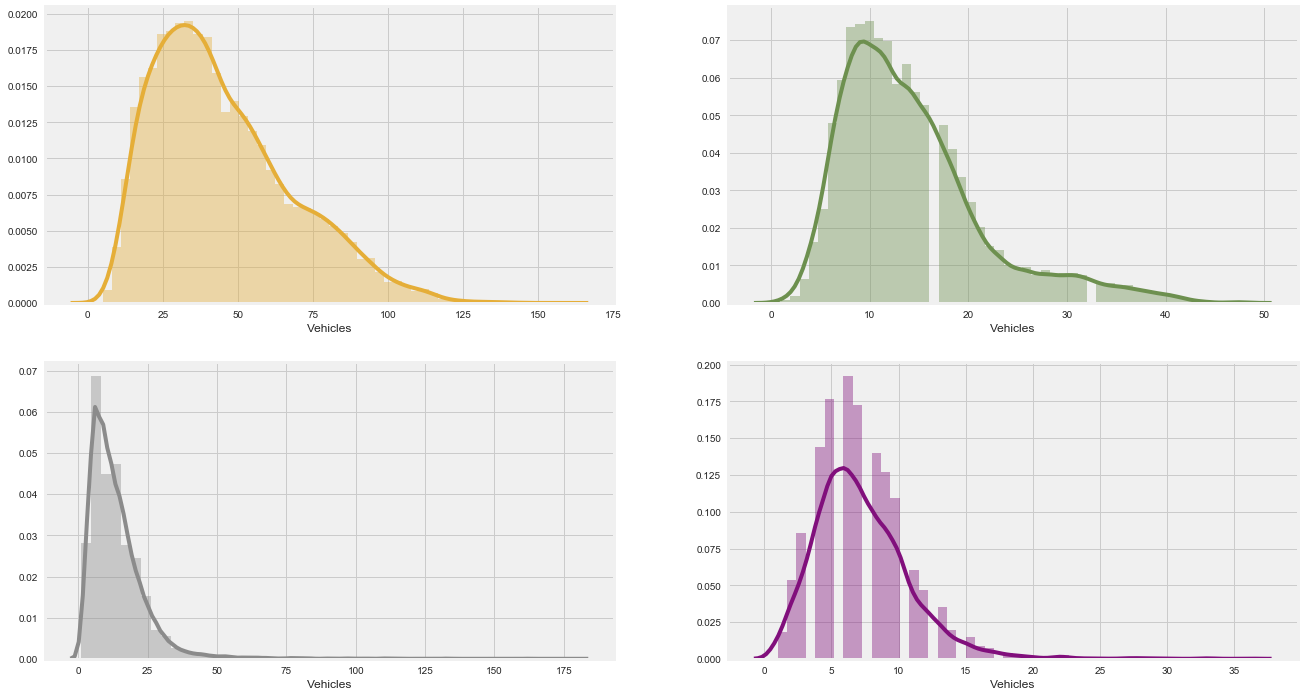

In [10]:
color = sns.color_palette()

plt.figure(figsize=(20, 12))

plt.subplot(221)
sns.distplot(combined[combined.Junction==1].Vehicles.dropna(), color=color[2])

plt.subplot(222)
sns.distplot(combined[combined.Junction==2].Vehicles.dropna(), color=color[3])

plt.subplot(223)
sns.distplot(combined[combined.Junction==3].Vehicles.dropna(), color=color[4])

plt.subplot(224)
sns.distplot(combined[combined.Junction==4].Vehicles.dropna(), color=color[5])

Let's take a quick look at the trends over time. Are the number of vehicles at any specific junctions increasing over time?

Let's write a function to plot the number of vehicles over time. For simplicity, we will focus on the total vehicles passing through the junction at any given day - we can use the `df.groupby()` function to create a new dataframe.

In [11]:
color = sns.color_palette()

def date_vehicle_plot(df, freq):
    plt.figure(figsize=(20,20))

    for idx, jn in enumerate(sorted(list(set(df.Junction)))):
        df_ = df[df.Junction == jn]
        x_pos = np.arange(df_.shape[0])
        
        plt.subplot(2, 2, idx+1)
        plt.plot(x_pos, df_.Vehicles, '-', color=color[idx], linewidth=1)
        plt.xticks(x_pos[::freq], df_.Date.astype('str')[::freq], rotation='vertical')
        plt.title('Vehicles on Junction %s' % jn)
        
    plt.show()
    
combined['Date'] = combined.DateTime.apply(lambda date: dt.datetime.strptime(date[:10], '%Y-%m-%d'))

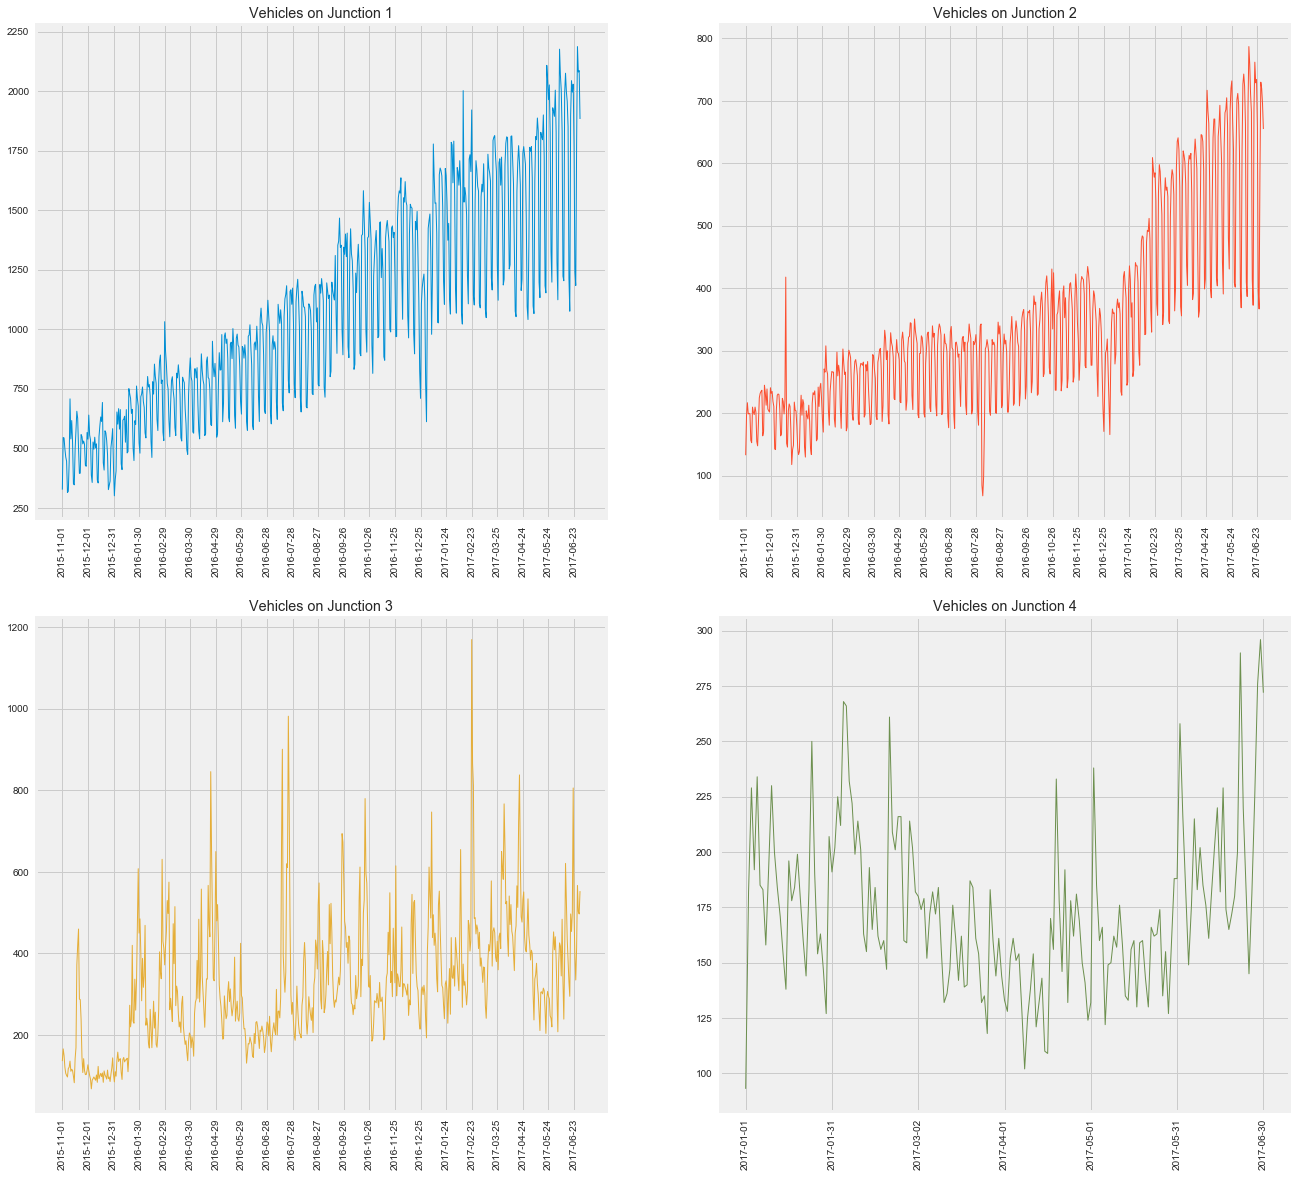

In [12]:
sum_groupby = combined.groupby(['Date', 'Junction']).sum().reset_index()

date_vehicle_plot(sum_groupby[pd.notnull(sum_groupby.Vehicles)], 30)

Generally, we see an upward trajectory of the number of cars passing through the 4 different junctions. In the plots, seasonalities seem to play a large part. Also, we note that during the winter period, the number of cars passing through the junctions are much lower.

During which time of the day do cars pass through the junctions at the highest rates?

In [13]:
def hour_vehicle_plot(df):
    plt.figure(figsize=(20,20))
    
    for idx, jn in enumerate(sorted(list(set(df.Junction)))):
        df_ = df[df.Junction == jn]
        x_pos = np.arange(df_.shape[0])
        
        plt.subplot(2, 2, idx+1)
        plt.plot(x_pos, df_.Vehicles, '-', color=color[idx], linewidth=1)
        plt.xticks(x_pos, df_.Hour, rotation='vertical')
        plt.title('Vehicles on Junction %s' % jn)
        
    plt.show()

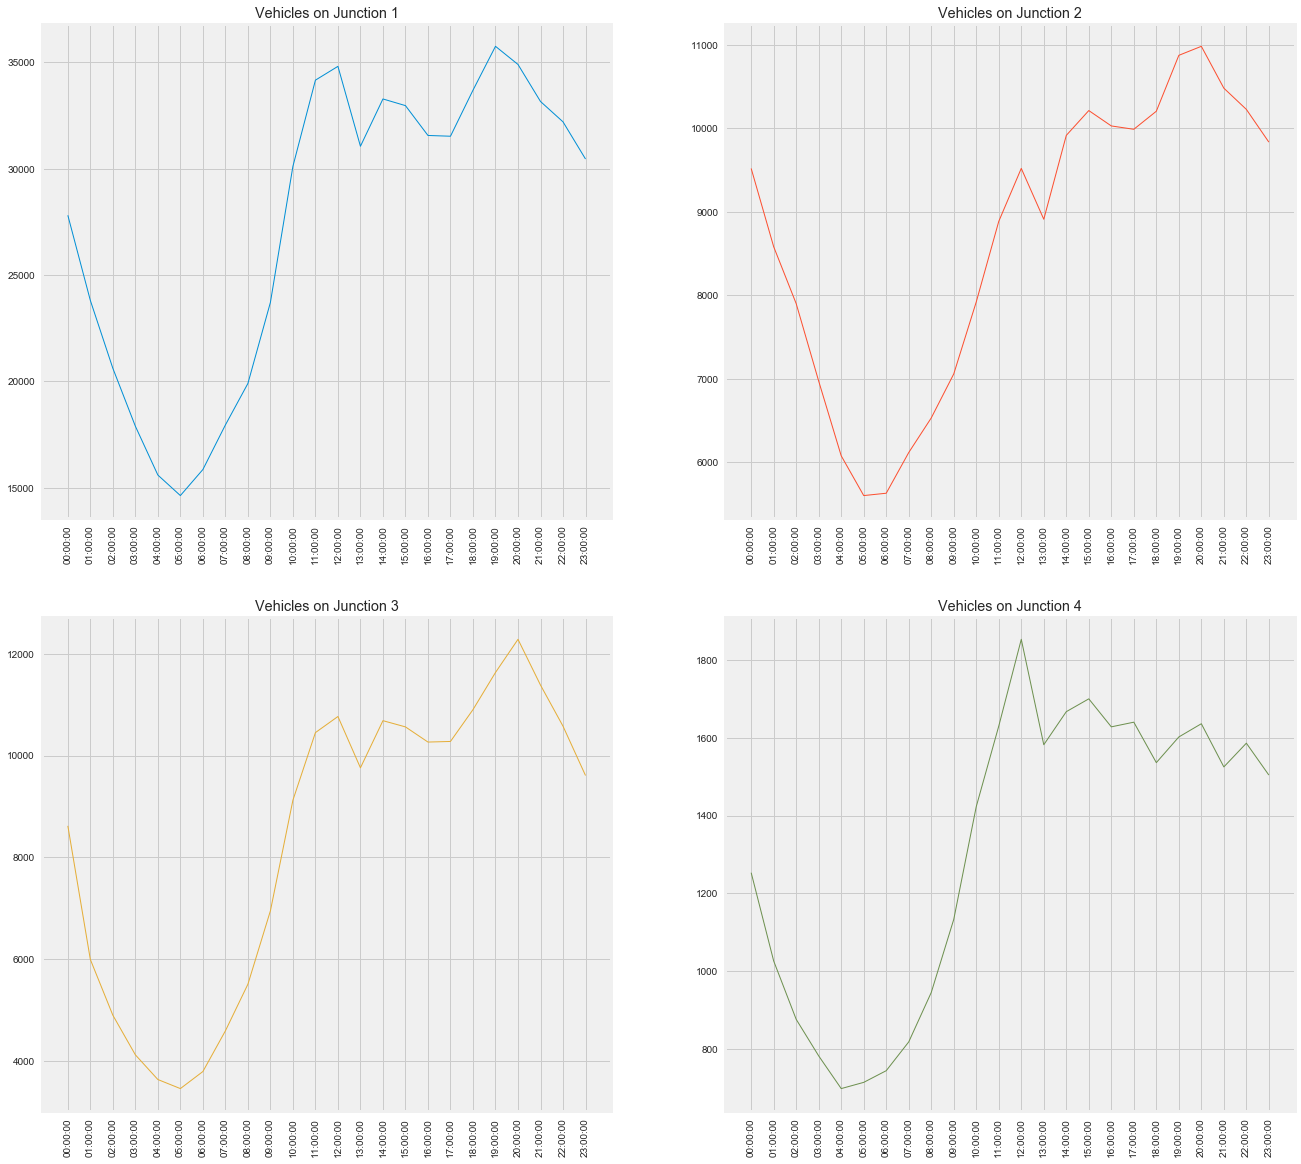

In [14]:
combined['Hour'] = combined.DateTime.apply(lambda date: date[11:])

sum_groupby = combined.groupby(['Hour', 'Junction']).sum().reset_index()

hour_vehicle_plot(sum_groupby[pd.notnull(sum_groupby.Vehicles)])

From the plot, it appears that different Junctions have different peak periods. However, during the early morning periods (from midnight to the afternoon), it appears that the distribution of Vehicles follows a **'U'** or **'V'** shape.

Finally, let's take a quick look at the distribution of the vehicles psasing over the 4 different junctions over time, and whether the weekend plays a difference.

In [15]:
def vehicle_plot(df):
    plt.figure(figsize=(20,20))
    
    for idx, jn in enumerate(sorted(list(set(df.Junction)))):
        df_ = df[df.Junction == jn]
        x_pos = np.arange(df_.shape[0])
        
        plt.subplot(2, 2, idx+1)
        plt.plot(x_pos, df_.Vehicles, '-', color=color[idx], linewidth=1)
        plt.title('Vehicles on Junction %s' % jn)
        
    plt.show()

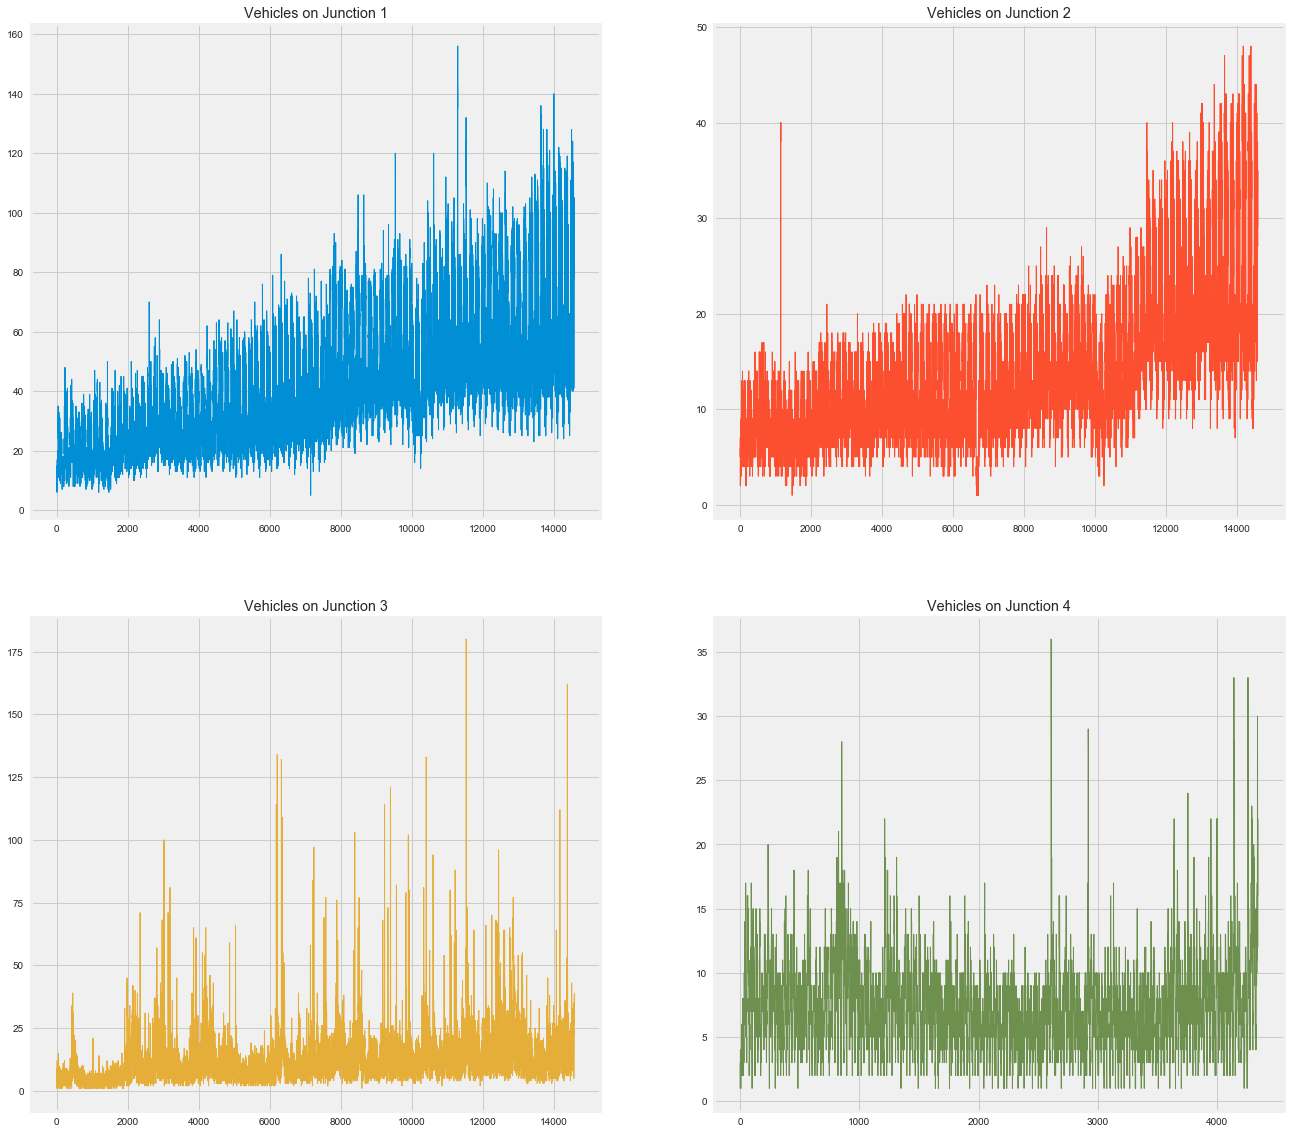

In [16]:
vehicle_plot(combined[pd.notnull(combined.Vehicles)])

What about weekends? Does it matter?

In [17]:
combined['Weekend'] = combined.Date.apply(lambda date: dt.datetime.weekday(date)) > 5

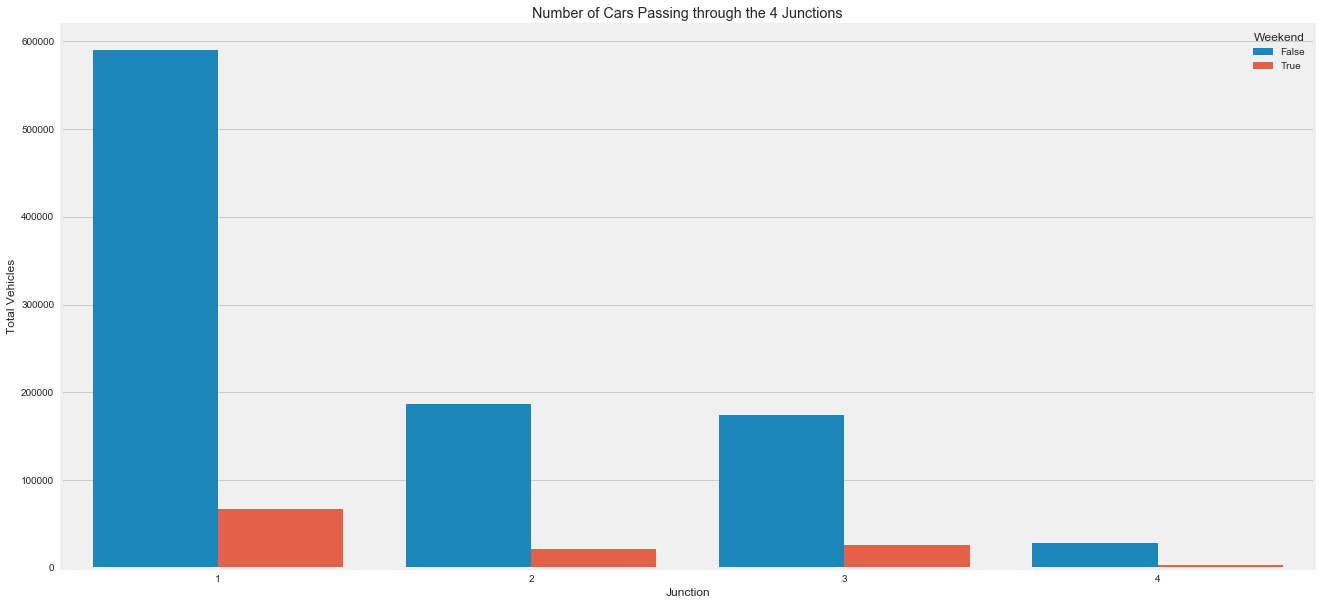

In [18]:
def weekend_weekday_plot():
    plt.figure(figsize=(20,10))
    
    df = combined.groupby(['Weekend', 'Junction']).sum().reset_index()
    sns.barplot(df.Junction, df.Vehicles, hue=df.Weekend)
    
    plt.title('Number of Cars Passing through the 4 Junctions')
    plt.ylabel('Total Vehicles')
    plt.show()
    
weekend_weekday_plot()

More cars pass through each junction during the weekday as compared to the weekend.

Let's us take a look at the correlation between the total number of vehicles across each junction over time. We will create a new dataframe for this.

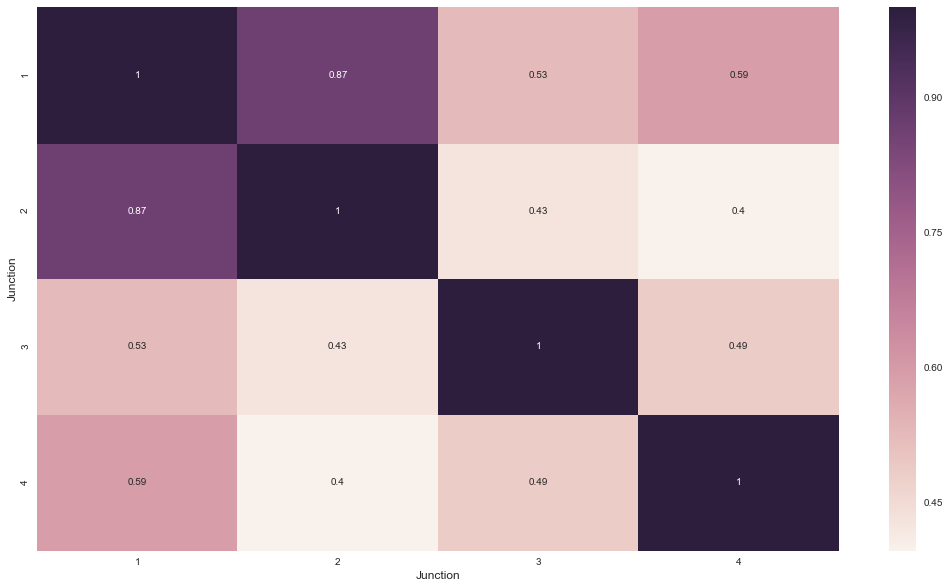

In [19]:
new_df = combined.groupby(['DateTime', 'Junction']).sum()['Vehicles'].reset_index().pivot(index='DateTime', 
                                                                                          columns='Junction', 
                                                                                          values='Vehicles')
plt.figure(figsize=(16,10))
sns.heatmap(new_df.corr(), annot=True)

The traffic passing through Junction 1 and 2 appears to be strongly correlated, with a correlation of 0.87. As for the correlation between traffic across the other junctions, it is not as strong as we have imagined.

### Feature Engineering - Phase 1

The creation of useful features can help us improve our forecast accuracy. For example, we expect that during public holidays, there might not be as many cars passing through the junctions as expected, as individuals stay home.

#### Public Holiday

Suppose we believe that during public holidays, the total number of vehicles passing through the junctions is significantly lower than during the total number of vehicles passing through the *legitimate* holidays. Adding a binary feature which accounts for this fact can improve our model.

Looking at the time series plot, it appears that Christmas and the New Year holidays were key holidays. Let's create a new groupby dataframe to try to understand which country the dataset is from.

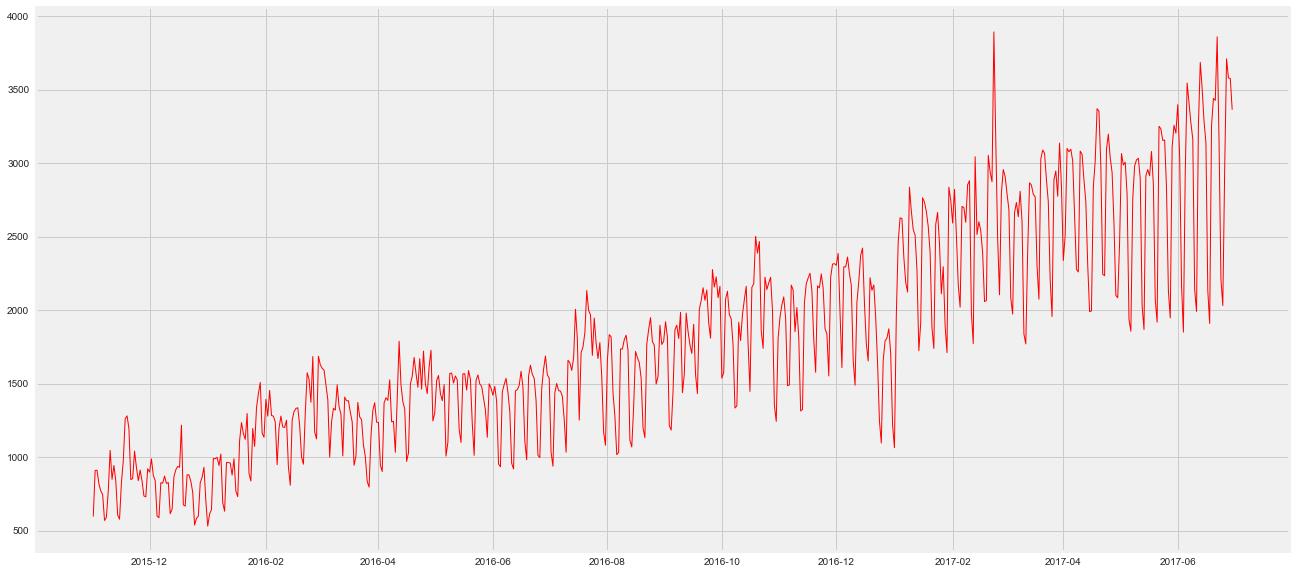

In [20]:
def plot_total_veh():
    plt.figure(figsize=(20, 10))
    
    df = combined.groupby(['Date']).sum()['Vehicles'].reset_index()
    plt.plot(df.Date, df.Vehicles, linewidth=1, color='red')
    
plot_total_veh()

#### Country of Origin

It appears that Christmas and New Year are key dates. Let's use the correlation between the Holidays of different countries and the Vehicles passing through the total Junctions to find out the country that the dataset is from.

In [21]:
date_groupby = combined.groupby(['Date']).sum().reset_index()

In [22]:
import holidays

country_name = ['Australia',
                'Austria',
                'Canada',
                'Colombia',
                'Czech',
                'Denmark',
                'England',
                'Germany',
                'Ireland',
                'Mexico',
                'Netherlands',
                'NewZealand',
                'Norway',
                'Portugal',
                'Scotland',
                'Spain',
                'UnitedKingdom',
                'UnitedStates']

def return_holidays(country_name, datelist):
    return [dt.date(Date.year, Date.month, Date.day) in getattr(holidays, country_name)() for Date in datelist]

holiday = pd.DataFrame()
for country in country_name:
    holiday[country] = return_holidays(country, date_groupby.Date)

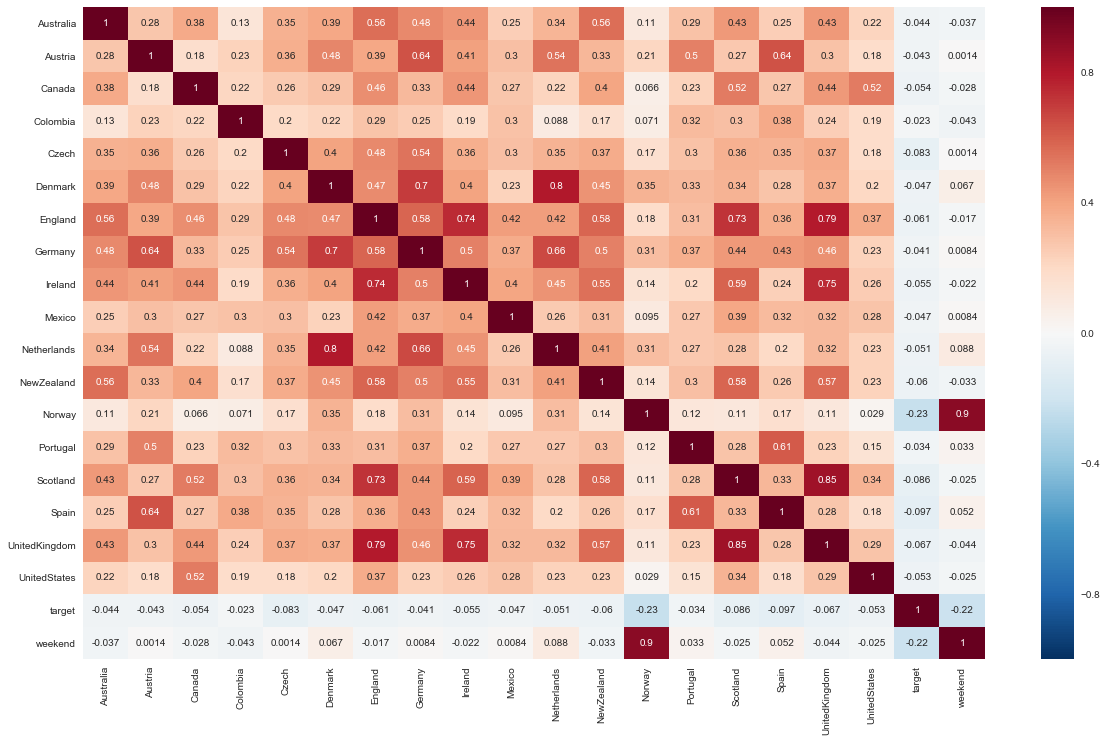

In [23]:
holiday['target'] = date_groupby.Vehicles
holiday['weekend'] = date_groupby.Weekend

plt.figure(figsize=(18,12))
sns.heatmap(holiday.corr(), annot=True)

Looking at the plot, it does appear that the dataframe comes from Norway. However, it is highly correlated with the 'Weekend' feature. To circumvent this issue, we take the second column which has the highest correlation with our target label - Spain.

In [24]:
es_holidays = holidays.Spain()

combined['Holiday'] = combined.Date.apply(lambda Date: dt.date(Date.year, Date.month, Date.day) in es_holidays)

Let's take a quick look at the correlation across different features in the dataframe.

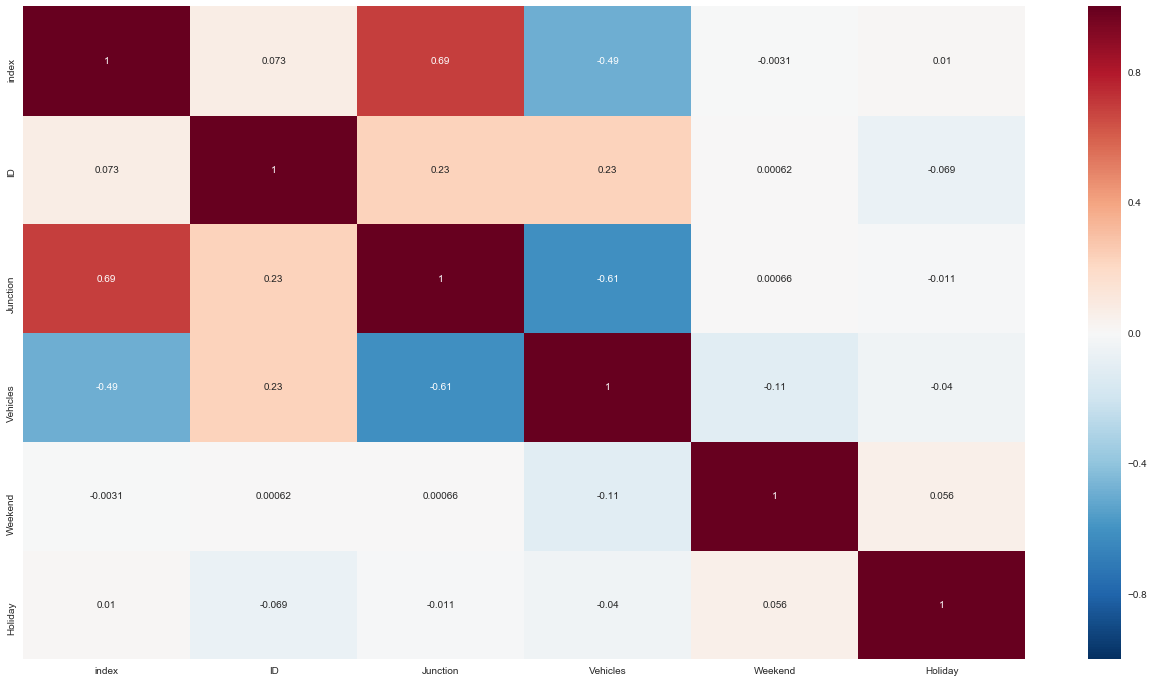

In [25]:
plt.figure(figsize=(20,12))
sns.heatmap(combined.corr(), annot=True)
plt.show()

### Model Fitting

Using what we have learnt until now, let's fit a model to predict for the future traffic across the 4 different junctions.

As a start, we create a dictionary which stores a dataframe for each junction to test for a unit root. 

In [26]:
# list_of_df refers to a dictionary of dataframes instead of a list of dataframe
list_of_df = {}
for junc in sorted(list(set(combined.Junction))): list_of_df[junc] = combined[combined.Junction == junc]

#### Cointegration vs Stationarity
Let's conduct an Augmented Dickey-Fuller test to test for the existence of a unit root in the dataframe. As we have previously noted that the vehicle traffic passing through Junction 1 and 2 displays trending behaviour over time, let's use 'ct' and 'ctt' as the regression parameter instead.

We will use daily data instead of hourly data for this exercise.

The code is adapted below from [IBM](https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c). 

ADF test-statistic for Junction 1


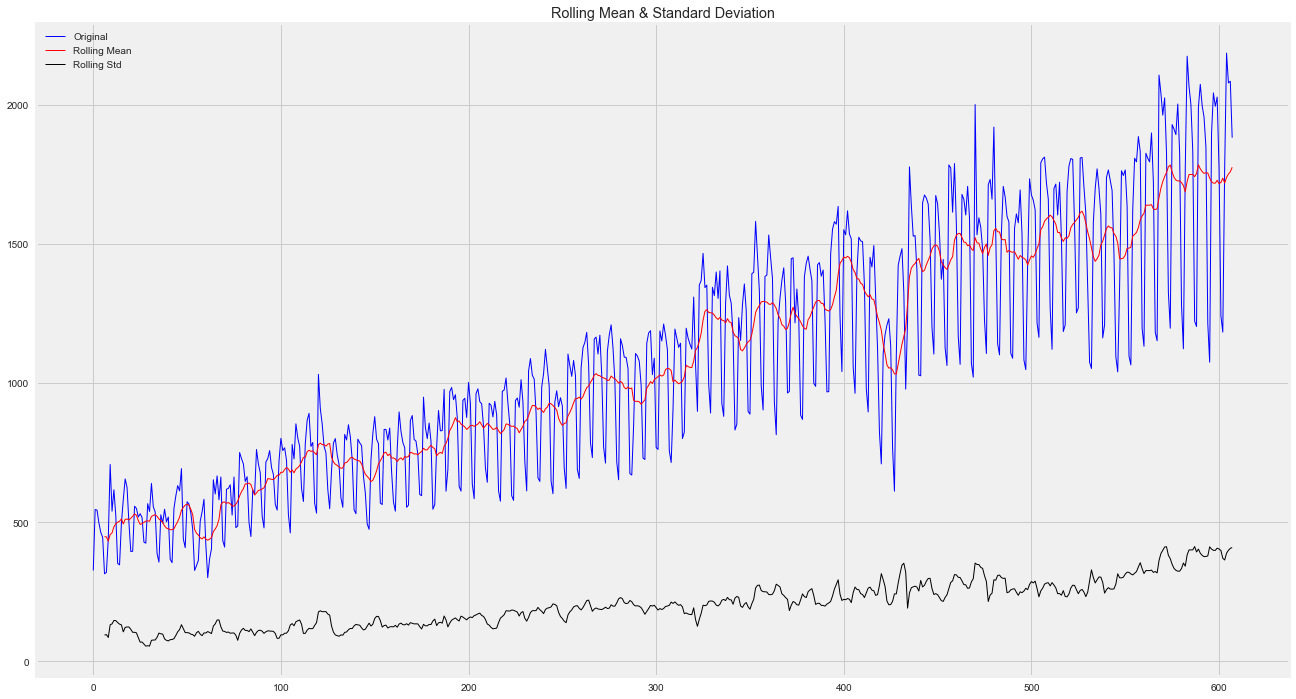

Results of Dickey-Fuller Test:
Test Statistic                  -5.924854
p-value                          0.000003
#Lags Used                      16.000000
Number of Observations Used    591.000000
Critical Value (5%)             -3.417945
Critical Value (1%)             -3.974170
Critical Value (10%)            -3.131436
dtype: float64


ADF test-statistic for Junction 2


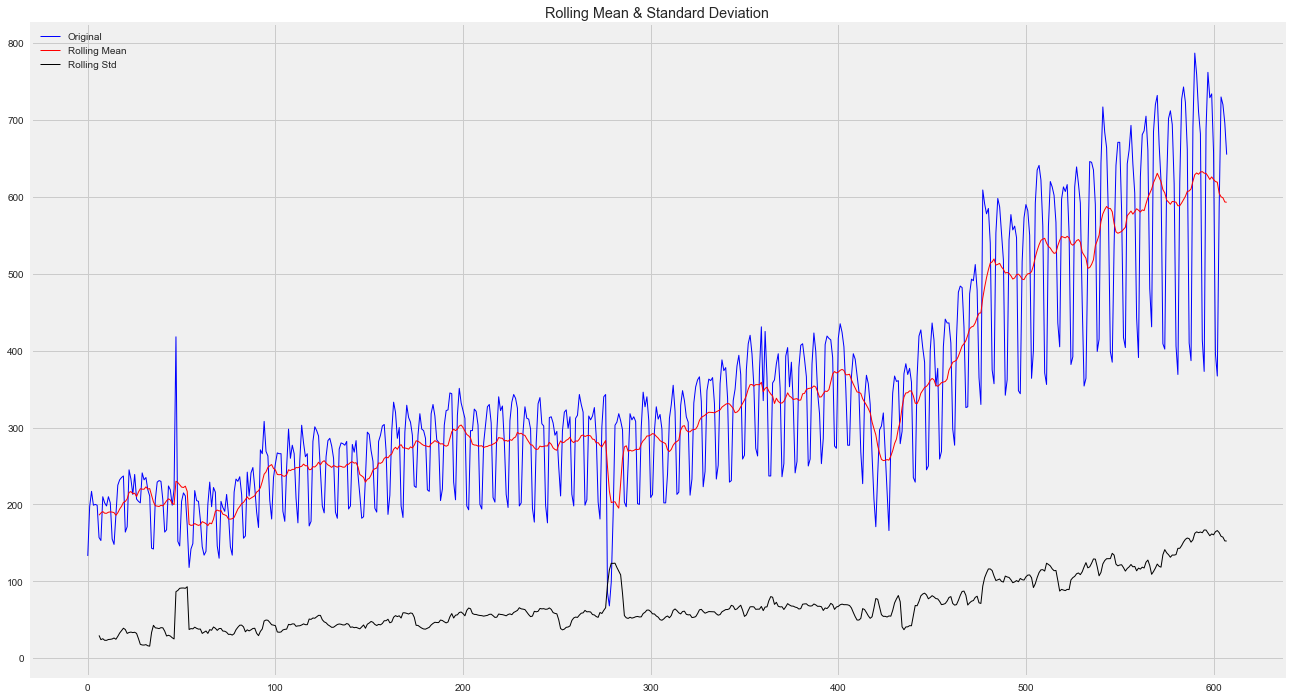

Results of Dickey-Fuller Test:
Test Statistic                  -2.494587
p-value                          0.572456
#Lags Used                      19.000000
Number of Observations Used    588.000000
Critical Value (5%)             -3.842470
Critical Value (1%)             -4.390943
Critical Value (10%)            -3.559499
dtype: float64


ADF test-statistic for Junction 3


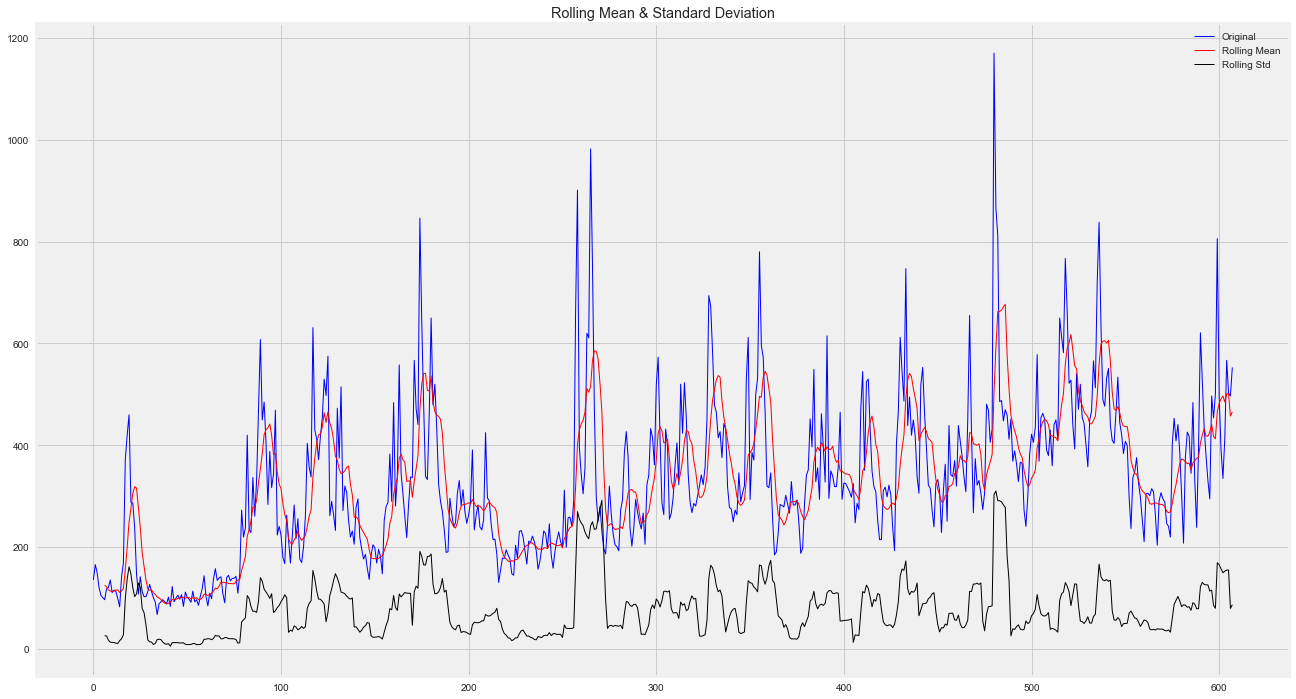

Results of Dickey-Fuller Test:
Test Statistic                -1.016229e+01
p-value                        1.051066e-15
#Lags Used                     0.000000e+00
Number of Observations Used    6.070000e+02
Critical Value (5%)           -3.417748e+00
Critical Value (1%)           -3.973762e+00
Critical Value (10%)          -3.131320e+00
dtype: float64


ADF test-statistic for Junction 4


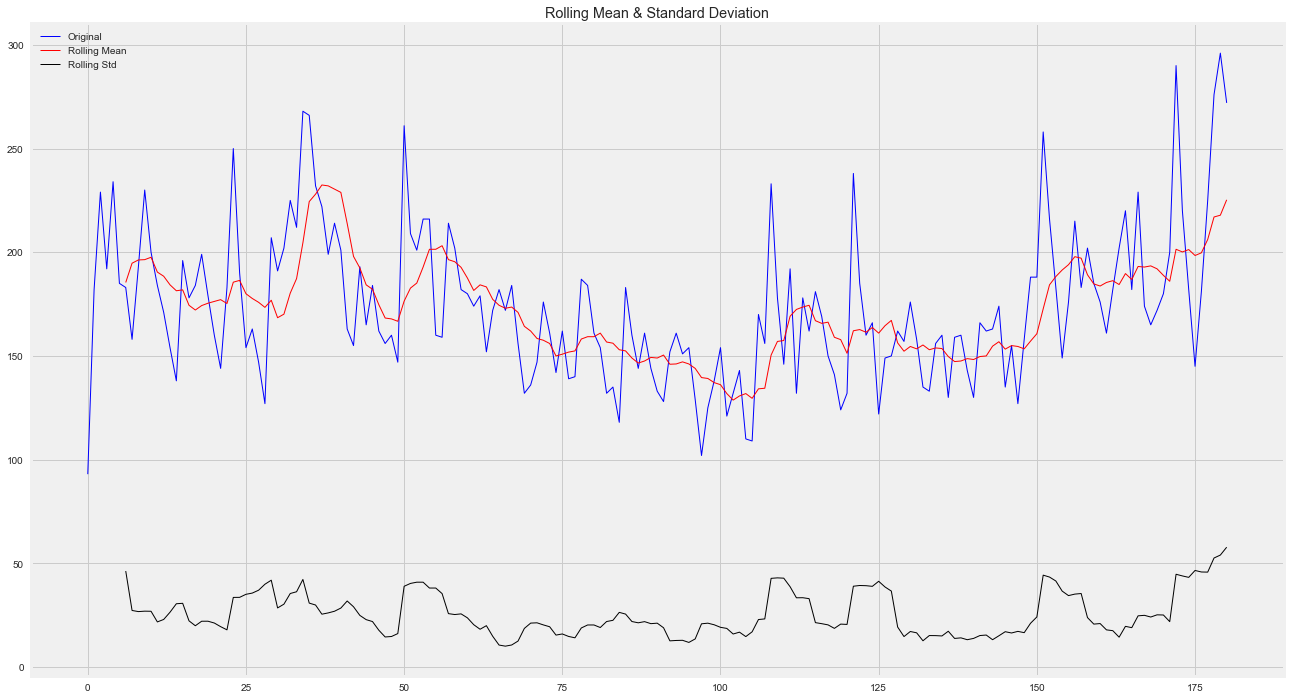

Results of Dickey-Fuller Test:
Test Statistic                  -0.749583
p-value                          0.833485
#Lags Used                      13.000000
Number of Observations Used    167.000000
Critical Value (5%)             -2.879008
Critical Value (1%)             -3.470126
Critical Value (10%)            -2.576083
dtype: float64




In [27]:
from statsmodels.tsa.stattools import adfuller

def teststationarity(timeseries, reg): 
    #Determing rolling statistics - a window period of 7 was used (weekly rolling mean)
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 12))
    orig = plt.plot(timeseries, '-', color='blue', label='Original', linewidth=1)
    mean = plt.plot(rolmean, '-', color='red', label='Rolling Mean', linewidth=1)
    std = plt.plot(rolstd, '-', color='black', label = 'Rolling Std', linewidth=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, regression=reg, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

reg = ['ct', 'ctt', 'ct', 'c']

for junc, reg_ in zip(sorted(list(set(combined.Junction))), reg):
    print 'ADF test-statistic for Junction %d' % junc
    teststationarity(list_of_df[junc].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles, reg_)
    print '\n'

Using the daily sum of the total vehicles passing through the junctions, 2 out of 4 series appear to have a unit root - Total Vehicles passing through Junction 2 and 4.

As an aside, we do observe that as time passes, the rolling standard deviation across the 4 different junctions have increased slightly.

To find the optimal number of lags to use in our AR model, we can use the PACF and ACF function.

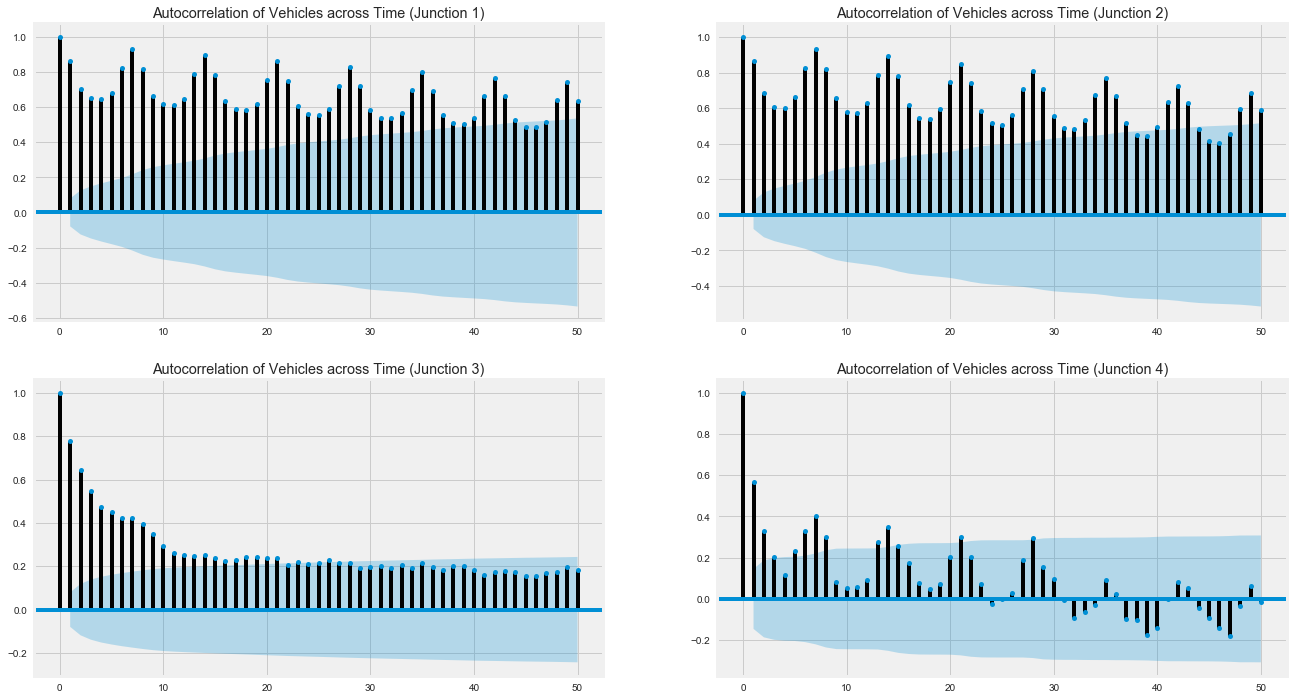

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12))

fig = plot_acf(list_of_df[1].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
               lags = 50, ax=ax1, 
               title='Autocorrelation of Vehicles across Time (Junction 1)')
fig = plot_acf(list_of_df[2].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
               lags = 50, ax=ax2, 
               title='Autocorrelation of Vehicles across Time (Junction 2)')
fig = plot_acf(list_of_df[3].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
               lags = 50, ax=ax3, 
               title='Autocorrelation of Vehicles across Time (Junction 3)')
fig = plot_acf(list_of_df[4].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
               lags = 50, ax=ax4, 
               title='Autocorrelation of Vehicles across Time (Junction 4)')

Looking at the ACF, it appears that there is a strong correlation across observations over time.

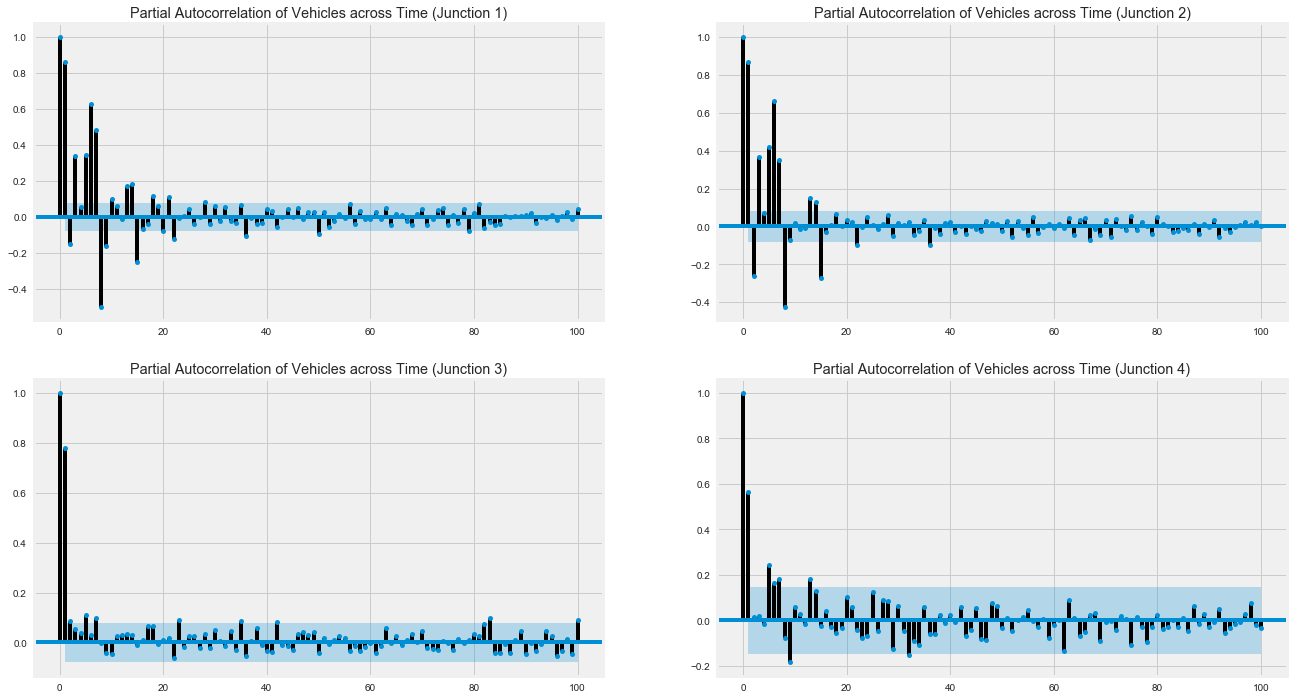

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12))

fig = plot_pacf(list_of_df[1].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
                lags = 100, ax=ax1, 
                title='Partial Autocorrelation of Vehicles across Time (Junction 1)')
fig = plot_pacf(list_of_df[2].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
                lags = 100, ax=ax2, 
                title='Partial Autocorrelation of Vehicles across Time (Junction 2)')
fig = plot_pacf(list_of_df[3].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
                lags = 100, ax=ax3, 
                title='Partial Autocorrelation of Vehicles across Time (Junction 3)')
fig = plot_pacf(list_of_df[4].groupby(['Date'])['Vehicles'].sum().reset_index().dropna().Vehicles,
                lags = 100, ax=ax4, 
                title='Partial Autocorrelation of Vehicles across Time (Junction 4)')

Similarly, the PACF seems to suggest that we adopt the following strategy:

1. Junction 1: Use 22 lags.
2. Junction 2: Use 22 lags.
3. Junction 3: Use 23 lags.
4. Junction 4: Use 14 lags.

### Feature Engineering - Phase 2

Looking across the 4 distributions, we do observe that there exists strong correlation across observations over time. As it turns out, we should **at least** include the first lag of the observation depending on the Junction.

In addition, we should also include a deterministic trend to predict for the traffic at Junction 1, as the total number of vehicles passing through Junction 1 display trending behavior.

We begin by mapping the features, Weekend and Holiday to integer variables before splitting the dataframe into a training and testing dataset. Also, we will include a new feature, the day of the week. We will include an additional feature, Month, to try to capture any remaining seasonalities which may occur in the dataset.

In addition, we make use of the temporal aspect of our dataframe - we will use the first n observations as our training set, and set the rest of the observations as the testing dataset.

In [30]:
sum_groupby = combined.groupby(['Date', 'Junction']).sum().reset_index()

junc1, junc2, junc3, junc4 = (sum_groupby[sum_groupby.Junction==1],
                              sum_groupby[sum_groupby.Junction==2],
                              sum_groupby[sum_groupby.Junction==3],
                              sum_groupby[sum_groupby.Junction==4])

In [31]:
def map_to_binary(x): 
    if x > 0: return 1
    else: return 0
    
junc1['Weekend'] = junc1['Weekend'].apply(map_to_binary)
junc2['Weekend'] = junc2['Weekend'].apply(map_to_binary)
junc3['Weekend'] = junc3['Weekend'].apply(map_to_binary)
junc4['Weekend'] = junc4['Weekend'].apply(map_to_binary)

junc1['Holiday'] = junc1['Holiday'].apply(map_to_binary)
junc2['Holiday'] = junc2['Holiday'].apply(map_to_binary)
junc3['Holiday'] = junc3['Holiday'].apply(map_to_binary)
junc4['Holiday'] = junc4['Holiday'].apply(map_to_binary)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [32]:
# Day of Week
junc1 = pd.merge(junc1, pd.get_dummies(junc1['Date'].apply(lambda Date: Date.weekday())),
                 left_index=True, right_index=True)

junc2 = pd.merge(junc2, pd.get_dummies(junc2['Date'].apply(lambda Date: Date.weekday())),
                 left_index=True, right_index=True)

junc3 = pd.merge(junc3, pd.get_dummies(junc3['Date'].apply(lambda Date: Date.weekday())),
                 left_index=True, right_index=True)

junc4 = pd.merge(junc4, pd.get_dummies(junc4['Date'].apply(lambda Date: Date.weekday())),
                 left_index=True, right_index=True)

In [33]:
junc1.set_index('Date', inplace=True)
junc2.set_index('Date', inplace=True)
junc3.set_index('Date', inplace=True)
junc4.set_index('Date', inplace=True)

In [34]:
id_junc1 = list_of_df[1][pd.isnull(list_of_df[1].Vehicles)]['ID']
id_junc2 = list_of_df[2][pd.isnull(list_of_df[2].Vehicles)]['ID']
id_junc3 = list_of_df[3][pd.isnull(list_of_df[3].Vehicles)]['ID']
id_junc4 = list_of_df[4][pd.isnull(list_of_df[4].Vehicles)]['ID']

Finally, let's remove features which are not informative of the target label.

In [35]:
junc1.columns.tolist()

['Junction',
 'index',
 'ID',
 'Vehicles',
 'Weekend',
 'Holiday',
 0,
 1,
 2,
 3,
 4,
 5,
 6]

In [36]:
for feature in ['Junction', 'index', 'ID']:
    del junc1[feature]
    del junc2[feature]
    del junc3[feature]
    del junc4[feature]

### SARIMAX model

Let's use an SARIMAX Model to predict for the total number of vehicles that will pass through the 4 junctions in our forecast horizon (We won't be using the S of SARIMAX in this case).

In this case, we will use the `SARIMAX` function (as it allows us to include endogenous variables) from the **[StatsModels](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)** library. The code was taken from [SARIMAX: Introduction](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html).

### Strategy

Our strategy will be as follows:

1. We predict the total number of vehicles passing through each junction on a daily basis.
2. Then, we obtain the composition of the total number of vehicles passing through each junction on an hourly basis.
3. Using the composition obtained along with the daily forecast, we are able to identify the traffic.

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X_feat = [feat for feat in junc1.columns if feat != 'Vehicles']; y_feat = 'Vehicles'

#### Junction 1

In [38]:
train_rows1 = junc1[pd.notnull(junc1.Vehicles)].shape[0]

In [39]:
model_junction1 = SARIMAX(junc1.iloc[:train_rows1].Vehicles, junc1.iloc[:train_rows1][X_feat], 
                          order=(22, 0, 0), trend='ct',
                          enforce_stationarity=False)

# AIC for this model is 6805.192
fit_res = model_junction1.fit(disp=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [40]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                  608
Model:              SARIMAX(22, 0, 0)   Log Likelihood               -3368.596
Date:                Wed, 31 Jan 2018   AIC                           6805.192
Time:                        15:15:39   BIC                           6955.138
Sample:                    11-01-2015   HQIC                          6863.529
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -213.6083     50.140     -4.260      0.000    -311.881    -115.336
drift          0.7028      0.162      4.350      0.000       0.386       1.019
Weekend      380.6075     64.126      5.935      0.000     254.922     506.293
Holiday     -104.1001     13.234     -7.866      0.000    -130.038     -78.163
0           1202.6884    112.077     10.731      0.000     983.022    1422.355
1           1233.1831    104.114     11.845      0.000    1029.123    1437.243
2           1225.8846    103.896     11.799      0.000    1022.252    1429.517
3           1208.2038    107.255     11.265      0.000     997.988    1418.419
4           1143.9563    104.764     10.919      0.000     938.623    1349.289
5            822.0879    114.356      7.189      0.000     597.955    1046.221
6            380.6075     64.126      5.935      0.000     254.922     506.293
ar.L1          0.4780      0.042     11.501      0.000       0.397       0.559
ar.L2          0.0783      0.056      1.387      0.165      -0.032       0.189
ar.L3          0.1027      0.061      1.689      0.091      -0.016       0.222
ar.L4         -0.0676      0.056     -1.198      0.231      -0.178       0.043
ar.L5          0.0295      0.052      0.567      0.571      -0.072       0.131
ar.L6          0.0616      0.056      1.104      0.270      -0.048       0.171
ar.L7          0.2280      0.050      4.541      0.000       0.130       0.326
ar.L8         -0.1259      0.059     -2.127      0.033      -0.242      -0.010
ar.L9         -0.1236      0.055     -2.250      0.024      -0.231      -0.016
ar.L10         0.0944      0.050      1.876      0.061      -0.004       0.193
ar.L11        -0.0305      0.047     -0.648      0.517      -0.123       0.062
ar.L12        -0.1558      0.054     -2.866      0.004      -0.262      -0.049
ar.L13         0.1347      0.058      2.332      0.020       0.021       0.248
ar.L14         0.2082      0.048      4.337      0.000       0.114       0.302
ar.L15         0.0028      0.054      0.052      0.959      -0.103       0.108
ar.L16        -0.1729      0.057     -3.054      0.002      -0.284      -0.062
ar.L17        -0.1252      0.060     -2.083      0.037      -0.243      -0.007
ar.L18        -0.0261      0.053     -0.494      0.621      -0.130       0.077
ar.L19         0.0863      0.049      1.765      0.078      -0.010       0.182
ar.L20        -0.0808      0.058     -1.398      0.162      -0.194       0.033
ar.L21         0.1769      0.045      3.960      0.000       0.089       0.264
ar.L22        -0.0910      0.056     -1.615      0.106      -0.201       0.019
sigma2      6459.1829    354.980     18.196      0.000    5763.435    7154.931
===================================================================================
Ljung-Box (Q):                       31.89   Jarque-Bera (JB):               173.57
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                

In [41]:
forecast_df_junc1 = junc1[pd.isnull(junc1.Vehicles)]

pred1 = fit_res.forecast(123, exog=forecast_df_junc1[X_feat])

Using the last 1200 hourly observations (or 50 days) to understand the composition of traffic in Junction 1 across the day.

In [42]:
junc1_hourly_decomp = (list_of_df[1][pd.notnull(list_of_df[1].Vehicles)][-1200:]
                       .groupby('Hour').sum())
junc1_hourly_decomp['Comp'] = junc1_hourly_decomp.Vehicles/sum(junc1_hourly_decomp.Vehicles)

Using the traffic forecast obtained from our ARIMA model, let's decompose the total number of vehicles passing through Junction 1 into the total observations per hour.

In [43]:
hourly_pred_junc1 = []
[hourly_pred_junc1.append(pred * comp) for pred in pred1 for comp in junc1_hourly_decomp.Comp]

hourly_veh1 = list_of_df[1][pd.notnull(list_of_df[1].Vehicles)].Vehicles.tolist() + hourly_pred_junc1

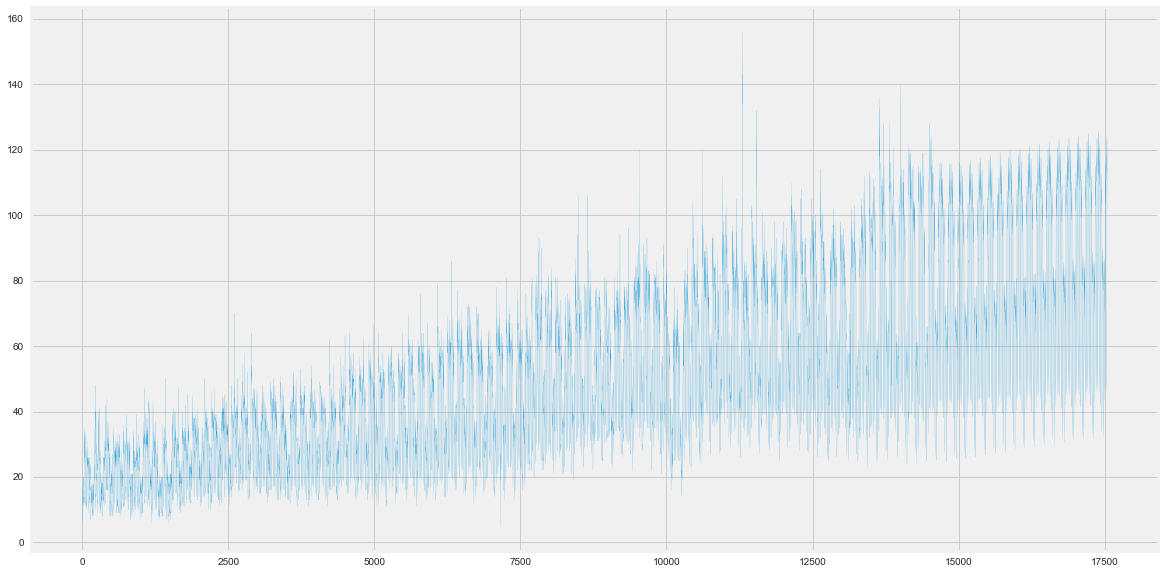

In [44]:
plt.figure(figsize=(18,10))
plt.plot(hourly_veh1, linewidth=0.1)

#### Junction 2

In [45]:
train_rows2 = junc2[pd.notnull(junc2.Vehicles)].shape[0]

In [46]:
model_junction2 = SARIMAX(junc2.iloc[:train_rows2].Vehicles, junc2.iloc[:train_rows2][X_feat], 
                          order=(22, 1, 0), trend=[1,1,1],
                          enforce_stationarity=True)

# AIC for this model is 5819.219
fit_res2 = model_junction2.fit(disp=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
fit_res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                  608
Model:              SARIMAX(22, 1, 0)   Log Likelihood               -2874.609
Date:                Wed, 31 Jan 2018   AIC                           5819.219
Time:                        15:16:01   BIC                           5973.575
Sample:                    11-01-2015   HQIC                          5879.271
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0304      4.405      0.007      0.994      -8.603       8.664
drift          0.0090      0.033      0.271      0.786      -0.056       0.074
trend.2    -2.068e-06   5.26e-05     -0.039      0.969      -0.000       0.000
Weekend      -51.9659     26.908     -1.931      0.053    -104.704       0.772
Holiday      -17.3656      4.920     -3.530      0.000     -27.008      -7.723
0             16.8591     53.309      0.316      0.752     -87.625     121.343
1             48.2875     36.781      1.313      0.189     -23.802     120.377
2             43.8756     40.959      1.071      0.284     -36.402     124.153
3             33.8630     46.798      0.724      0.469     -57.860     125.586
4              8.0051     42.114      0.190      0.849     -74.538      90.548
5            -98.9243     38.543     -2.567      0.010    -174.468     -23.381
6            -51.9659     26.908     -1.931      0.053    -104.704       0.772
ar.L1         -0.3826      0.025    -15.140      0.000      -0.432      -0.333
ar.L2         -0.4526      0.051     -8.918      0.000      -0.552      -0.353
ar.L3         -0.3818      0.046     -8.384      0.000      -0.471      -0.293
ar.L4         -0.3250      0.058     -5.634      0.000      -0.438      -0.212
ar.L5         -0.3344      0.063     -5.349      0.000      -0.457      -0.212
ar.L6         -0.2214      0.057     -3.900      0.000      -0.333      -0.110
ar.L7         -0.0095      0.055     -0.173      0.863      -0.117       0.098
ar.L8         -0.0773      0.061     -1.267      0.205      -0.197       0.042
ar.L9         -0.0974      0.073     -1.337      0.181      -0.240       0.045
ar.L10        -0.0644      0.071     -0.911      0.362      -0.203       0.074
ar.L11        -0.1111      0.061     -1.817      0.069      -0.231       0.009
ar.L12        -0.1632      0.067     -2.421      0.015      -0.295      -0.031
ar.L13        -0.1220      0.062     -1.973      0.048      -0.243      -0.001
ar.L14         0.1176      0.054      2.169      0.030       0.011       0.224
ar.L15         0.0011      0.066      0.017      0.986      -0.129       0.131
ar.L16        -0.0518      0.068     -0.757      0.449      -0.186       0.082
ar.L17        -0.0971      0.068     -1.432      0.152      -0.230       0.036
ar.L18        -0.0689      0.068     -1.014      0.311      -0.202       0.064
ar.L19        -0.1304      0.071     -1.830      0.067      -0.270       0.009
ar.L20        -0.0175      0.058     -0.301      0.763      -0.131       0.096
ar.L21         0.0926      0.057      1.626      0.104      -0.019       0.204
ar.L22         0.0812      0.060      1.353      0.176      -0.036       0.199
sigma2       769.0034     24.218     31.754      0.000     721.537     816.469
===================================================================================
Ljung-Box (Q):                       31.18   Jarque-Bera (JB):              7455.78
Prob(Q):                              0.84   Prob(JB):                 

In [48]:
forecast_df_junc2 = junc2[pd.isnull(junc2.Vehicles)]

pred2 = fit_res2.forecast(123, exog=forecast_df_junc2[X_feat])

In [49]:
junc2_hourly_decomp = (list_of_df[2][pd.notnull(list_of_df[2].Vehicles)][-1200:]
                       .groupby('Hour').sum())
junc2_hourly_decomp['Comp'] = junc2_hourly_decomp.Vehicles/sum(junc2_hourly_decomp.Vehicles)

In [50]:
hourly_pred_junc2 = []
[hourly_pred_junc2.append(pred * comp) for pred in pred2 for comp in junc2_hourly_decomp.Comp]

hourly_veh2 = list_of_df[2][pd.notnull(list_of_df[2].Vehicles)].Vehicles.tolist() + hourly_pred_junc2

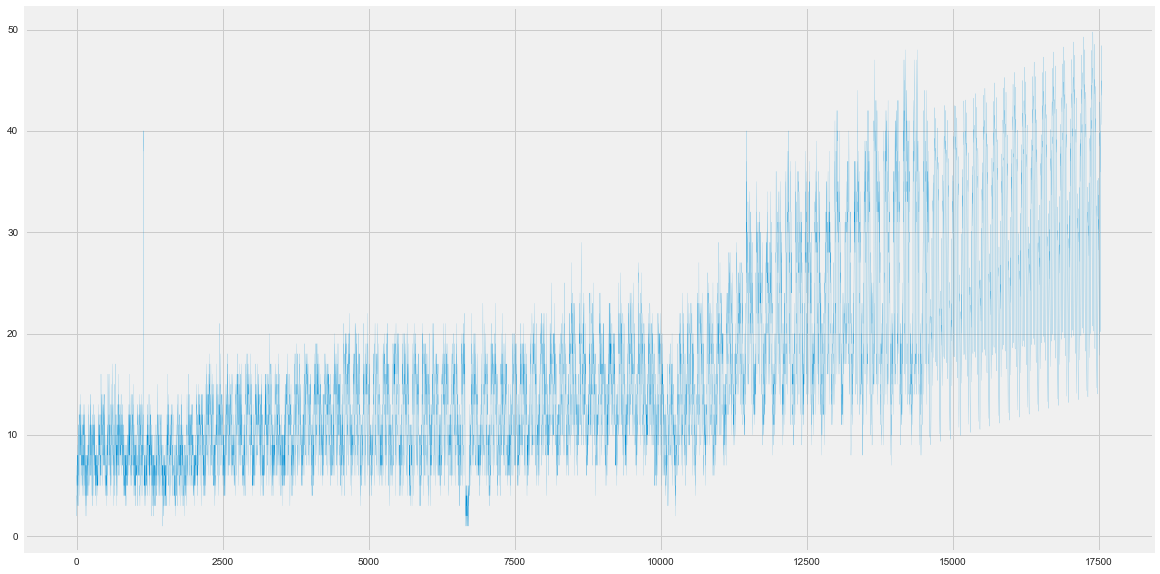

In [51]:
plt.figure(figsize=(18,10))
plt.plot(hourly_veh2, linewidth=0.1)

#### Junction 3

In [52]:
train_rows3 = junc3[pd.notnull(junc3.Vehicles)].shape[0]

In [53]:
model_junction3 = SARIMAX(junc3.iloc[:train_rows3].Vehicles, junc3.iloc[:train_rows3][X_feat], 
                          order=(23, 0, 0), trend='ct',
                          enforce_stationarity=True)

# AIC for this model is 7262.114
fit_res3 = model_junction3.fit(disp=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [54]:
fit_res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                  608
Model:              SARIMAX(23, 0, 0)   Log Likelihood               -3596.057
Date:                Wed, 31 Jan 2018   AIC                           7262.114
Time:                        15:16:34   BIC                           7416.470
Sample:                    11-01-2015   HQIC                          7322.166
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -39.0274     13.044     -2.992      0.003     -64.593     -13.462
drift          0.1258      0.036      3.493      0.000       0.055       0.196
Weekend      151.6053      5.894     25.722      0.000     140.053     163.157
Holiday      -19.4867     30.849     -0.632      0.528     -79.949      40.975
0            330.8261     14.159     23.365      0.000     303.075     358.577
1            319.8672     13.002     24.602      0.000     294.385     345.350
2            322.4145     11.002     29.306      0.000     300.852     343.977
3            342.4148     10.172     33.662      0.000     322.478     362.352
4            343.4343     10.210     33.636      0.000     323.422     363.446
5            353.5399     10.463     33.790      0.000     333.033     374.047
6            151.6053      5.894     25.722      0.000     140.053     163.157
ar.L1          0.6913      0.037     18.518      0.000       0.618       0.764
ar.L2          0.0080      0.050      0.159      0.873      -0.091       0.107
ar.L3          0.0282      0.050      0.566      0.571      -0.069       0.126
ar.L4         -0.0412      0.058     -0.714      0.475      -0.154       0.072
ar.L5          0.0627      0.052      1.209      0.227      -0.039       0.164
ar.L6         -0.0271      0.051     -0.535      0.593      -0.127       0.072
ar.L7          0.0332      0.045      0.731      0.465      -0.056       0.122
ar.L8          0.0810      0.051      1.601      0.109      -0.018       0.180
ar.L9         -0.0306      0.057     -0.540      0.589      -0.142       0.080
ar.L10        -0.0709      0.070     -1.007      0.314      -0.209       0.067
ar.L11        -0.0049      0.065     -0.076      0.940      -0.131       0.122
ar.L12        -0.0085      0.070     -0.122      0.903      -0.145       0.128
ar.L13         0.0325      0.052      0.619      0.536      -0.070       0.135
ar.L14        -0.0323      0.055     -0.590      0.556      -0.140       0.075
ar.L15         0.0422      0.063      0.670      0.503      -0.081       0.166
ar.L16        -0.0821      0.068     -1.205      0.228      -0.216       0.051
ar.L17         0.0370      0.072      0.513      0.608      -0.104       0.178
ar.L18         0.0688      0.074      0.925      0.355      -0.077       0.214
ar.L19        -0.0316      0.070     -0.454      0.650      -0.168       0.105
ar.L20         0.0063      0.062      0.101      0.919      -0.115       0.128
ar.L21        -0.0122      0.067     -0.182      0.855      -0.143       0.118
ar.L22        -0.0585      0.068     -0.854      0.393      -0.193       0.076
ar.L23         0.0426      0.054      0.783      0.433      -0.064       0.149
sigma2      8019.4281    390.371     20.543      0.000    7254.315    8784.541
===================================================================================
Ljung-Box (Q):                       10.93   Jarque-Bera (JB):              2735.60
Prob(Q):                              1.00   Prob(JB):                 

In [55]:
forecast_df_junc3 = junc3[pd.isnull(junc3.Vehicles)]

pred3 = fit_res3.forecast(123, exog=forecast_df_junc3[X_feat])

In [56]:
junc3_hourly_decomp = (list_of_df[3][pd.notnull(list_of_df[3].Vehicles)][-1200:]
                       .groupby('Hour').sum())
junc3_hourly_decomp['Comp'] = junc3_hourly_decomp.Vehicles/sum(junc3_hourly_decomp.Vehicles)

In [57]:
hourly_pred_junc3 = []
[hourly_pred_junc3.append(pred * comp) for pred in pred3 for comp in junc3_hourly_decomp.Comp]

hourly_veh3 = list_of_df[3][pd.notnull(list_of_df[3].Vehicles)].Vehicles.tolist() + hourly_pred_junc3

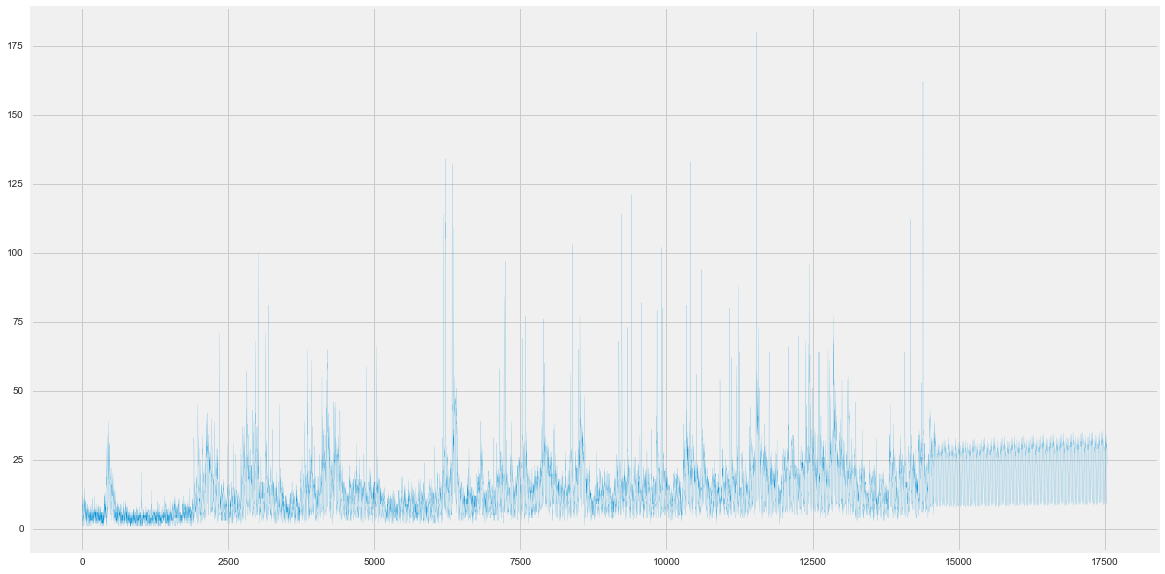

In [58]:
plt.figure(figsize=(18,10))
plt.plot(hourly_veh3, linewidth=0.1)

#### Junction 4

In [59]:
train_rows4 = junc4[pd.notnull(junc4.Vehicles)].shape[0]

In [60]:
model_junction4 = SARIMAX(junc4.iloc[:train_rows4].Vehicles, junc4.iloc[:train_rows4][X_feat], 
                          order=(14, 1, 0), trend='n',
                          enforce_stationarity=True)

# AIC for this model is 1686.522
fit_res4 = model_junction4.fit(disp=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [61]:
fit_res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                  181
Model:              SARIMAX(14, 1, 0)   Log Likelihood                -819.261
Date:                Wed, 31 Jan 2018   AIC                           1686.522
Time:                        15:16:37   BIC                           1763.286
Sample:                    01-01-2017   HQIC                          1717.644
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekend      -16.9944   3.24e+04     -0.001      1.000   -6.35e+04    6.35e+04
Holiday      -29.1609     12.183     -2.394      0.017     -53.040      -5.282
0              2.9617   6.48e+04   4.57e-05      1.000   -1.27e+05    1.27e+05
1             13.1616   6.48e+04      0.000      1.000   -1.27e+05    1.27e+05
2              7.9450   6.48e+04      0.000      1.000   -1.27e+05    1.27e+05
3             13.3395   6.48e+04      0.000      1.000   -1.27e+05    1.27e+05
4             -0.1959   6.48e+04  -3.02e-06      1.000   -1.27e+05    1.27e+05
5            -20.2167   6.48e+04     -0.000      1.000   -1.27e+05    1.27e+05
6            -16.9944   3.24e+04     -0.001      1.000   -6.36e+04    6.35e+04
ar.L1         -0.4694      0.085     -5.493      0.000      -0.637      -0.302
ar.L2         -0.3646      0.094     -3.864      0.000      -0.549      -0.180
ar.L3         -0.3283      0.094     -3.481      0.001      -0.513      -0.143
ar.L4         -0.4149      0.119     -3.475      0.001      -0.649      -0.181
ar.L5         -0.1467      0.112     -1.311      0.190      -0.366       0.073
ar.L6         -0.1261      0.116     -1.084      0.278      -0.354       0.102
ar.L7         -0.2045      0.106     -1.932      0.053      -0.412       0.003
ar.L8         -0.0705      0.115     -0.613      0.540      -0.296       0.155
ar.L9         -0.2021      0.120     -1.687      0.092      -0.437       0.033
ar.L10        -0.2695      0.121     -2.223      0.026      -0.507      -0.032
ar.L11        -0.2493      0.124     -2.013      0.044      -0.492      -0.007
ar.L12        -0.1446      0.129     -1.122      0.262      -0.397       0.108
ar.L13        -0.0273      0.097     -0.280      0.780      -0.218       0.164
ar.L14        -0.0918      0.079     -1.165      0.244      -0.246       0.063
sigma2       522.6469     50.097     10.433      0.000     424.459     620.835
===================================================================================
Ljung-Box (Q):                       23.60   Jarque-Bera (JB):                52.01
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.99
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+16. Standard errors may be unstable.
"""

In [62]:
forecast_df_junc4 = junc4[pd.isnull(junc4.Vehicles)]

pred4 = fit_res4.forecast(123, exog=forecast_df_junc4[X_feat])

In [63]:
junc4_hourly_decomp = (list_of_df[4][pd.notnull(list_of_df[4].Vehicles)][-1200:]
                       .groupby('Hour').sum())
junc4_hourly_decomp['Comp'] = junc4_hourly_decomp.Vehicles/sum(junc4_hourly_decomp.Vehicles)

In [64]:
hourly_pred_junc4 = []
[hourly_pred_junc4.append(pred * comp) for pred in pred4 for comp in junc4_hourly_decomp.Comp]

hourly_veh4 = list_of_df[4][pd.notnull(list_of_df[4].Vehicles)].Vehicles.tolist() + hourly_pred_junc4

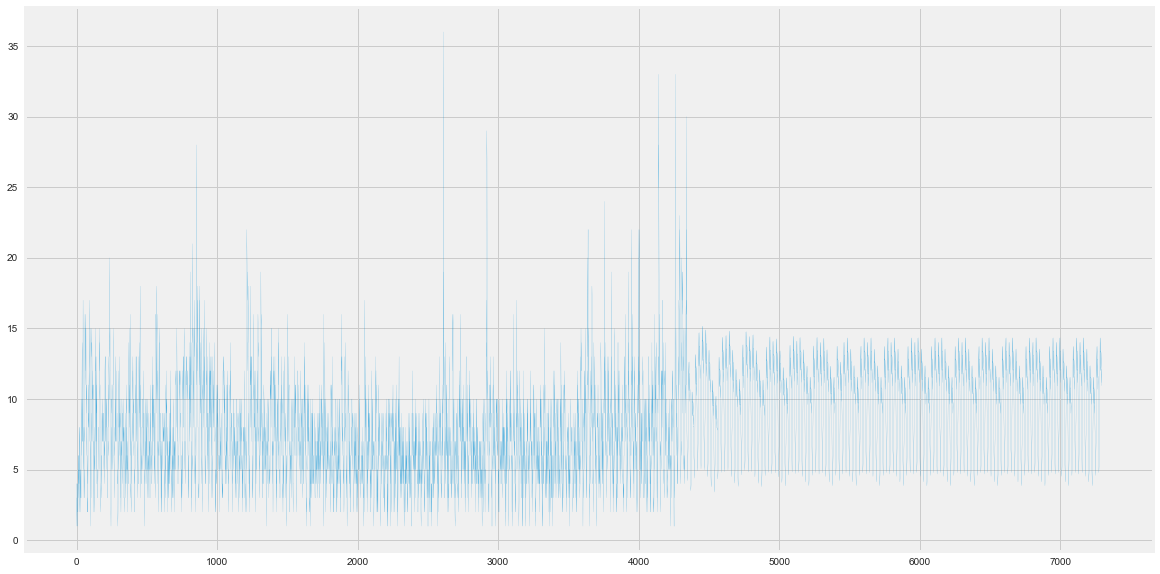

In [65]:
plt.figure(figsize=(18,10))
plt.plot(hourly_veh4, linewidth=0.1)

Let's submit our forecast! Let's amalgamate our existing predictions into one Series, and save it to a file.

In [66]:
vehicles = pd.concat([pd.Series(hourly_pred_junc1),
                      pd.Series(hourly_pred_junc2),
                      pd.Series(hourly_pred_junc3),
                      pd.Series(hourly_pred_junc4)])

id_ = pd.concat([pd.Series(id_junc1),
                 pd.Series(id_junc2),
                 pd.Series(id_junc3),
                 pd.Series(id_junc4)])

submission = pd.read_csv('data/sample_submission_EZmX9uE.csv')

In [67]:
submission['ID'], submission['Vehicles'] = id_.values, vehicles.values

In [68]:
submission.to_csv('data/FinalSubmission.csv',index=False)